In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob
import os

from moviepy.editor import VideoFileClip
from IPython.display import HTML

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from scipy.ndimage.measurements import label

%matplotlib inline

ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

### Camera Calibration

In [2]:
objPoints = [] # 3D Points in real world space
imgPoints = [] # 2D points in image plane

objp = np.zeros((6*9, 3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

In [3]:
nx = 9
ny = 6

images = glob.glob("camera_cal/calibration*.jpg")
for fname in images:    
    # Read in an image and grayscale it
    image = cv2.imread(fname)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    #Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        # Draw and display the corners
        objPoints.append(objp)
        imgPoints.append(corners)
        cv2.drawChessboardCorners(image, (nx, ny), corners, ret)

### Save calibration coordinates

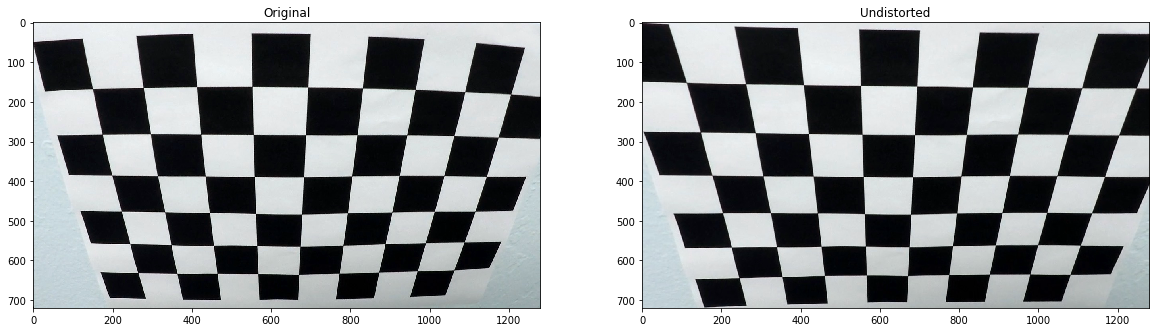

In [4]:
def undistort_image(image):
    global mtx
    global dist
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objPoints, imgPoints, (gray.shape[1], gray.shape[0]), None, None)
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    return undist

chess_board_image = cv2.imread("camera_cal/calibration3.jpg")

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(chess_board_image)
ax1.set_title('Original')
ax2.imshow(undistort_image(chess_board_image))
ax2.set_title('Undistorted')

In [5]:
calib_pickle = {}
calib_pickle["mtx"] = mtx
calib_pickle["dist"] = dist
pickle.dump( calib_pickle, open( "camera_calib_pickle.p", "wb" ) )

with open('camera_calib_pickle.p', mode='rb') as f:
    dist_pickle = pickle.load(f)
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]

### Gradient, Threshold Tranform

In [6]:
def binary_tranform(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the l and s channels
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    channels = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary))       
    binary_output = np.zeros_like(sxbinary)
    binary_output[(s_binary == 1) | (sxbinary==1)] = 1
    return binary_output

### Perspective Transform an Image

In [7]:
def perpective_tranform_coords(img):
    img_size = (img.shape[1], img.shape[0])
    
    corners = np.float32([[245, 697], [585, 456], [720, 456], [1156, 697]])
    new_top_left=np.array([corners[0,0],0])
    new_top_right=np.array([corners[3,0],0])
    
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([corners[0],corners[1],corners[2],corners[3]])
    dst = np.float32([corners[0],new_top_left,new_top_right-[30,0], corners[3]-[30,0]])
    
    return src, dst

In [8]:
def warp_image(img):
    img_size = (img.shape[1], img.shape[0])
    src, dst = perpective_tranform_coords(img)
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, M, Minv

### Calculate Polyfit models for left and right lanes

In [9]:
def perform_window_slide(img):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((img, img, img))*255
        
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)        
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
    
        # Drawing the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
   
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
 
    # Fit a second order polynomial to each
    left_fit = None
    right_fit = None
    
    # Fit a second order polynomial to each
    if len(leftx) != 0 and len(lefty) != 0 and len(rightx) != 0 and len(righty) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)    
        right_fit = np.polyfit(righty, rightx, 2)
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return out_img, left_fit, right_fit

def update_polyfit_models(img, prev_left_fit, prev_right_fit):
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Set the width of the windows +/- margin
    margin = 100

    left_lane_inds = ((nonzerox > (prev_left_fit[0]*(nonzeroy**2) + prev_left_fit[1]*nonzeroy + prev_left_fit[2] - margin)) & (nonzerox < (prev_left_fit[0]*(nonzeroy**2) + prev_left_fit[1]*nonzeroy + prev_left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (prev_right_fit[0]*(nonzeroy**2) + prev_right_fit[1]*nonzeroy + prev_right_fit[2] - margin)) & (nonzerox < (prev_right_fit[0]*(nonzeroy**2) + prev_right_fit[1]*nonzeroy + prev_right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit = None
    right_fit = None
    
    # Fit a second order polynomial to each
    if len(leftx) != 0 and len(lefty) != 0 and len(rightx) != 0 and len(righty) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit

### Calculate lane curvature (Real world space)

In [10]:
def calculate_curvature(img, left_fit, right_fit):
    # Generate x and y values
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Choose the max y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad =  ((1 + (2*left_fit_cr[0] *y_eval*ym_per_pix + left_fit_cr[1])**2) **1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    return left_curverad, right_curverad

In [31]:
def convert_to_real_space(img, warped, left_fit, right_fit, Minv):
    # Create an output image to draw on and  visualize the result
    new_warped = np.dstack((warped, warped, warped))*255
    
    # Generate x and y values
    ploty = np.linspace(0, new_warped.shape[0]-1, new_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw the lines on
    color_warp = np.zeros_like(new_warped).astype(np.uint8)
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the polygon representing the lane over the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Draw the lane lines onto the warped blank image
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=25)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(255,0,255), thickness=25)
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))

    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    return result

### Define Lane Line Class

In [12]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients of the last iteration
        self.last_fit = None
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [34]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

### Pipeline - Define pipeline to process video frame

In [14]:
def lane_curvature_data(img, left_fit, right_fit):
    h = img.shape[0]
    w = img.shape[1]
        
    left_x_intercept = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
    right_x_intercept = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
    
    lane_center_position = (right_x_intercept + left_x_intercept)/2
    lane_distance_from_center = abs((w/2)-lane_center_position)*xm_per_pix
    left_curve_rad, right_curve_rad = calculate_curvature(img, left_fit, right_fit)
    
    return left_curve_rad, right_curve_rad, lane_distance_from_center, left_x_intercept, right_x_intercept

def process_image(img, left_line, right_line):
    copy_img = np.copy(img)
    
    undistort_img = undistort_image(copy_img)
    binary_img = binary_tranform(undistort_img)
    binary_warped_img, _, Minv = warp_image(binary_img)
    
    if not left_line.detected or not right_line.detected:
        _, left_fit, right_fit = perform_window_slide(binary_warped_img)
    else:
        left_fit, right_fit = update_polyfit_models(binary_warped_img, left_line.last_fit, right_line.last_fit)
    
    if left_fit is not None and right_fit is not None:
        left_curve_rad, right_curve_rad, lane_distance_from_center, left_x_intercept, right_x_intercept = lane_curvature_data(img, left_fit, right_fit)
        lane_width = abs(left_x_intercept-right_x_intercept)*xm_per_pix
        
        #sanity checks
        if (left_curve_rad != 0 and right_curve_rad != 0) and (lane_width > 3.5 and lane_width < 4.5):
            left_line.last_fit = left_fit
            right_line.last_fit = right_fit
        
            left_line.detected = True
            right_line.detected = True
        else:
            #reset to perform window sliding
            left_line.detected = False
            right_line.detected = False 
    else:
        left_line.detected = False
        right_line.detected = False 
            
    if left_line.last_fit is not None and right_line.last_fit is not None:
        out_img = convert_to_real_space(copy_img, binary_warped_img, left_line.last_fit, right_line.last_fit, Minv)        
        out_img_with_text = np.copy(out_img)
        
        left_curve_rad, right_curve_rad, lane_distance_from_center, left_x_intercept, right_x_intercept = lane_curvature_data(binary_warped_img, left_line.last_fit, right_line.last_fit)
        lane_width = abs(left_x_intercept-right_x_intercept)*xm_per_pix

        text = 'Curvature - {:04.2f} m'.format((left_curve_rad+right_curve_rad)/2)
        cv2.putText(out_img_with_text, text, (50,50), cv2.FONT_HERSHEY_DUPLEX, 1.0, (0,255,155), 2, cv2.LINE_AA)
        text = 'Lane width - {:04.2f} m'.format(lane_width)
        cv2.putText(out_img_with_text, text, (50,100), cv2.FONT_HERSHEY_DUPLEX, 1.0, (0,255,155), 2, cv2.LINE_AA)
            
        out_img = out_img_with_text
    else:
        out_img = copy_img
    
    # Detect Vehicles
    
    return out_img

### Test/Verify Pipeline

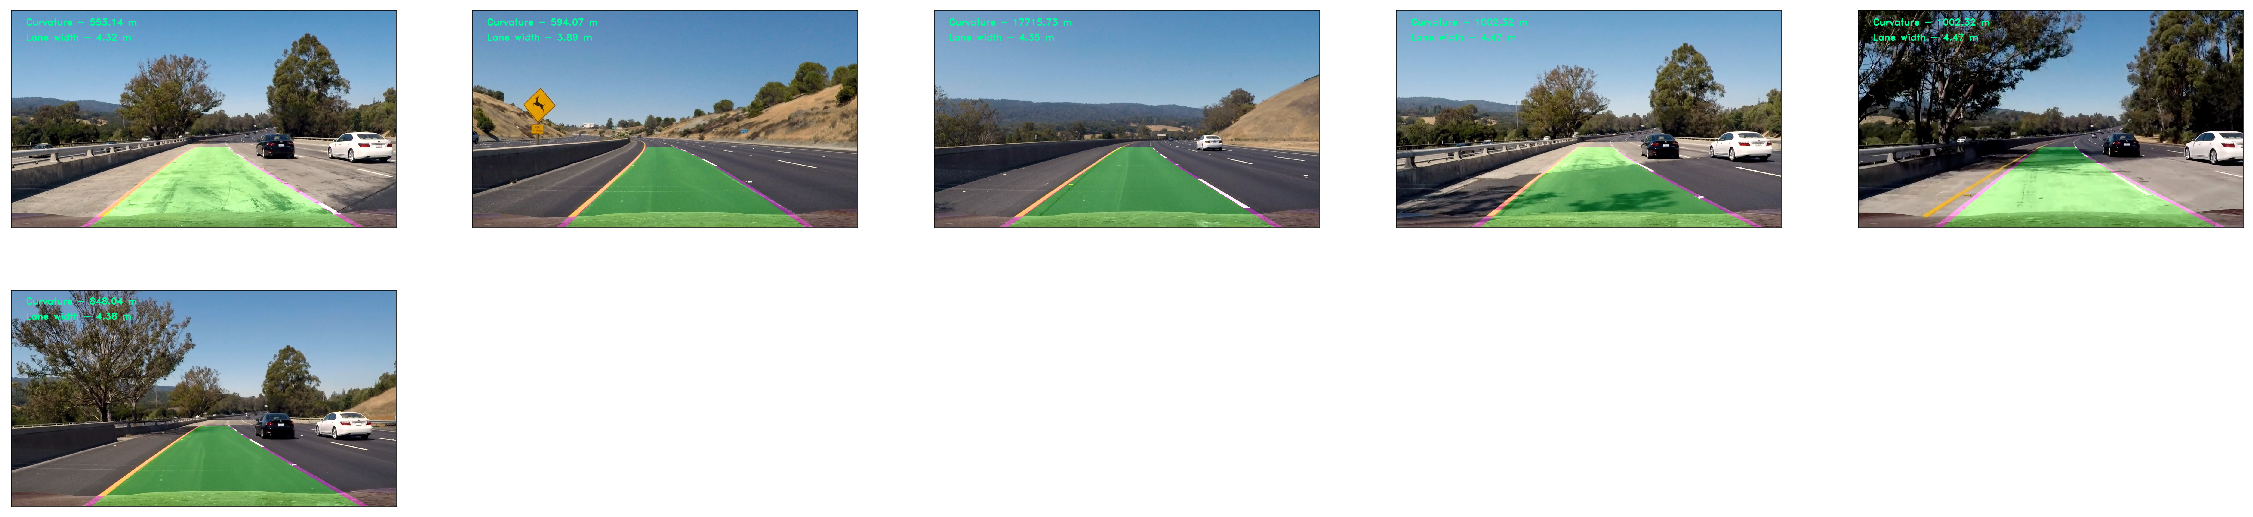

In [32]:
images = glob.glob("test_images/test*.jpg")
processed_imgs = []

left_line = Line()
right_line = Line()

for fname in images:    
    # Read in an image and grayscale it
    image = cv2.imread(fname)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    result = process_image(image, left_line, right_line)
    processed_imgs.append(result)

plt.rcParams['figure.figsize'] = (40,30)

for c in range(0, len(processed_imgs)):
    plt.subplot(6, 5, c+1)
    plt.imshow(processed_imgs[c])
    plt.tick_params(
        which='both', bottom='off', left='off', top='off', right='off', labelbottom='off', labelleft='off')

### Process Video

In [ ]:
left_line = Line()
right_line = Line()

def video_frame_processor(img):
    return process_image(img, left_line, right_line)

clip1 = VideoFileClip("project_video.mp4")
video_output = clip1.fl_image(video_frame_processor) 

if not os.path.isfile("project_video.mp4"):
    exit
        
%time video_output.write_videofile('project_video_output.mp4', audio=False)